# TNM112 -- Lab 3

2024-12-19 11:43:44.197719: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data specification:
	Dataset type:           cifar10
	Number of classes:      10
	Number of channels:     3
	Training data shape:    (3000, 32, 32, 3)
	Validation data shape:  (5000, 32, 32, 3)
	Test data shape:        (10000, 32, 32, 3)


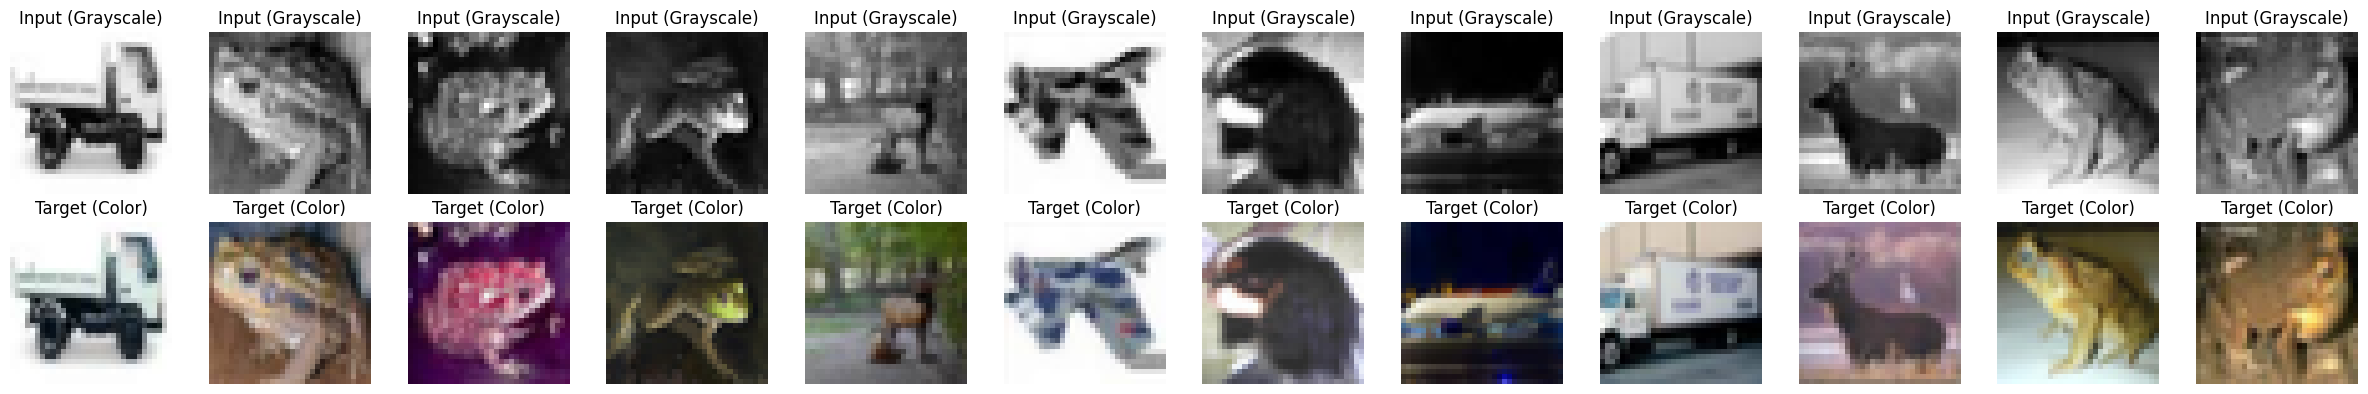

In [1]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import util
import data_generator
import numpy as np
import matplotlib.pyplot as plt

data = data_generator.DataGenerator()

data.generate(dataset='cifar10', N_train=3000, N_valid=0.1)
data.plot()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 32, 32, 64)           0         ['batch_normalization[0][0

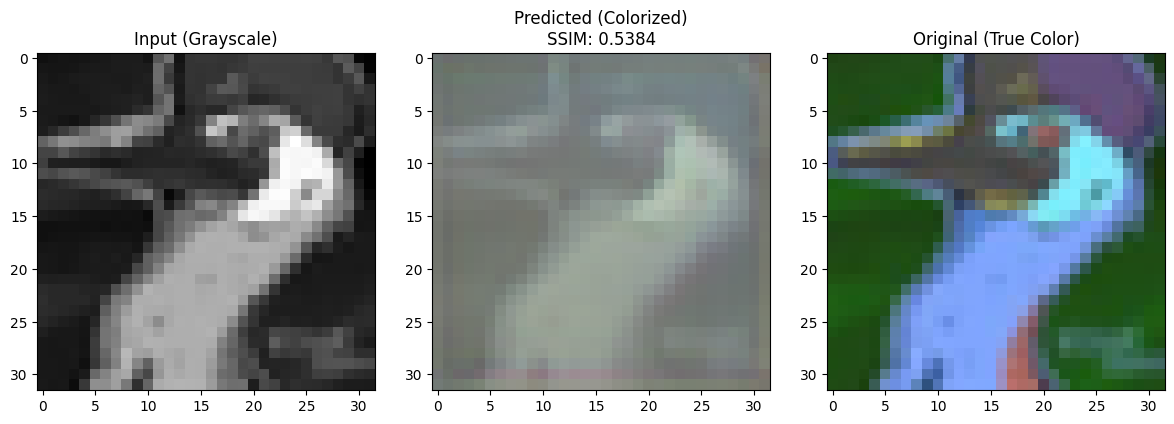

In [2]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import util
import data_generator
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from tensorflow.keras import layers, models
import tensorflow as tf

def colorization_cnn(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation=None, padding="same")(inputs)
    x = layers.BatchNormalization()(conv1)
    x = layers.ReLU()(x) 
    pool1 = layers.MaxPooling2D((2, 2), padding="same")(x)
   
    conv2 = layers.Conv2D(128, (3, 3), activation=None, padding="same")(pool1)
    x = layers.BatchNormalization()(conv2)
    x = layers.ReLU()(x)
    pool2 = layers.MaxPooling2D((2, 2), padding="same")(x)
   
    conv3 = layers.Conv2D(256, (3, 3), activation=None, padding="same")(pool2)  
    x = layers.BatchNormalization()(conv3)
    x = layers.ReLU()(x)
    pool3 = layers.MaxPooling2D((2, 2), padding="same")(x)
   
    # Bottleneck
    bottleneck = layers.Conv2D(512, (3, 3), activation=None, padding="same")(pool3) 
    x = layers.BatchNormalization()(bottleneck)
    x = layers.ReLU()(x)
   
    # Decoder 
    up3 = layers.UpSampling2D((2, 2))(x)
    concat3 = layers.concatenate([up3, conv3])
    conv4 = layers.Conv2D(256, (3, 3), activation=None, padding="same")(concat3)
    x = layers.BatchNormalization()(conv4)
    x = layers.ReLU()(x)

    up2 = layers.UpSampling2D((2, 2))(x)
    concat2 = layers.concatenate([up2, conv2])
    conv5 = layers.Conv2D(128, (3, 3), activation=None, padding="same")(concat2)
    x = layers.BatchNormalization()(conv5)
    x = layers.ReLU()(x)
   
    up1 = layers.UpSampling2D((2, 2))(x)
    concat1 = layers.concatenate([up1, conv1])
    conv6 = layers.Conv2D(64, (3, 3), activation=None, padding="same")(concat1)
    x = layers.BatchNormalization()(conv6)
    x = layers.ReLU()(x)
   
    outputs = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x) 
   
    model = models.Model(inputs, outputs)
    return model

epochs = 1
batch_size = 32

input_shape = data.x_train_gray.shape[1:] 

model = colorization_cnn(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

log = model.fit(data.x_train_gray, data.x_train, batch_size=batch_size, epochs=epochs,
                validation_data=(data.x_valid_gray, data.x_valid), validation_freq=1)

util.evaluate(model, data)

# Generate a random sample for evaluation
sample_idx = np.random.randint(len(data.x_valid))
grayscale_input = data.x_valid_gray[sample_idx]
predicted_color = model.predict(np.expand_dims(grayscale_input, axis=0))[0]
real_color_image = data.x_valid[sample_idx] 

# Convert predicted and original images to float
predicted_color = img_as_float(predicted_color)
real_color_image = img_as_float(real_color_image)

print(f"Predicted image shape: {predicted_color.shape}")
print(f"Real image shape: {real_color_image.shape}")

# Compute metrics
ssim_score = util.compute_ssim(predicted_color, real_color_image)
snr_score = util.compute_snr(predicted_color, real_color_image)
scielab_score = util.compute_scielab(predicted_color, real_color_image)

print(f"SSIM: {ssim_score:.4f}")
print(f"SNR: {snr_score:.2f} dB")
print(f"SCIELAB: {scielab_score:.4f}")

# Plot results
plt.figure(figsize=(12, 4))

# Grayscale input
plt.subplot(1, 3, 1)
plt.imshow(grayscale_input.squeeze(), cmap='gray')
plt.title("Input (Grayscale)")

# Predicted Colorized Image
plt.subplot(1, 3, 2)
plt.imshow(predicted_color)
plt.title(f"Predicted (Colorized)\nSSIM: {ssim_score:.4f}")

# Original (True Color) Image
plt.subplot(1, 3, 3)
plt.imshow(real_color_image)
plt.title("Original (True Color)")

plt.tight_layout()
plt.show()